In [1]:
%%capture
!pip install ai-edge-torch==0.4.0
!pip install gcpds-cv-pykit

In [2]:
import gc
import time
import wandb
import numpy as np
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from typing import Dict, List, Any, Tuple
import ai_edge_torch
from ai_edge_litert.interpreter import Interpreter
import torch
import torch.nn as nn
from gcpds_cv_pykit.segmentation.baseline.models import UNet
from gcpds_cv_pykit.segmentation.datasets import SeedGermination
from gcpds_cv_pykit.segmentation.baseline.dataloaders import Segmentation_DataLoader
from gcpds_cv_pykit.segmentation.visuals import random_sample_visualization

2025-11-25 04:16:42.736901: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764044202.781507      38 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764044202.795563      38 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764044202.843649      38 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764044202.843702      38 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764044202.843705      38 computation_placer.cc:177] computation placer alr

In [3]:
# Set a seed
seed = 42

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [4]:
SeedGermination('lucasiturriago/seeds/versions/1')

Path to downloaded dataset files: /kaggle/input/seeds
Original dataset folder '/kaggle/input/seeds' is read-only. Using it directly.


'/kaggle/input/seeds'

In [5]:
!mkdir -p /kaggle/working/datasets/seeds/
!cp -r /kaggle/input/seeds/ /kaggle/working/datasets/

/usr/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [6]:
config = {"Dir of dataset":"./datasets/seeds","Batch size": 1,"Image size":(256,256),"Epochs":61,
          "Input size":(3,256,256),"Number of classes":3,"Single class train":None,"Single class test":None,
          "Single class valid":None,"Images folder":"images","Data augmentation":True,"Model":"UNet",
          "Pretrained":True,"Save results":True,"Train phases":True,"Activation function": "sigmoid","Backbone":"mobilenetv3"}

In [7]:
train_dataset = Segmentation_DataLoader(config["Dir of dataset"], config["Batch size"], config["Image size"], config["Number of classes"],
                                        "Train", config["Single class train"], config["Data augmentation"], config["Images folder"],pin_memory=False)

Searching for images in: datasets/seeds/Train/images
Supported formats: *.png, *.jpg, *.jpeg
Number of image files found: 2458


Organizing masks: 100%|██████████| 2458/2458 [00:00<00:00, 66051.61it/s]


In [8]:
valid_dataset = Segmentation_DataLoader(config["Dir of dataset"], 1, config["Image size"], config["Number of classes"],
                                        "Valid", config["Single class valid"], config["Data augmentation"], config["Images folder"],pin_memory=False)

Searching for images in: datasets/seeds/Valid/images
Supported formats: *.png, *.jpg, *.jpeg
Number of image files found: 231


Organizing masks: 100%|██████████| 231/231 [00:00<00:00, 51616.02it/s]


In [9]:
test_dataset = Segmentation_DataLoader(config["Dir of dataset"], config["Batch size"], config["Image size"], config["Number of classes"],
                                        "Test", config["Single class test"], config["Data augmentation"], config["Images folder"],pin_memory=False)

Searching for images in: datasets/seeds/Test/images
Supported formats: *.png, *.jpg, *.jpeg
Number of image files found: 118


Organizing masks: 100%|██████████| 118/118 [00:00<00:00, 49766.50it/s]


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Images: torch.Size([1, 3, 256, 256]), Masks: torch.Size([1, 3, 256, 256])


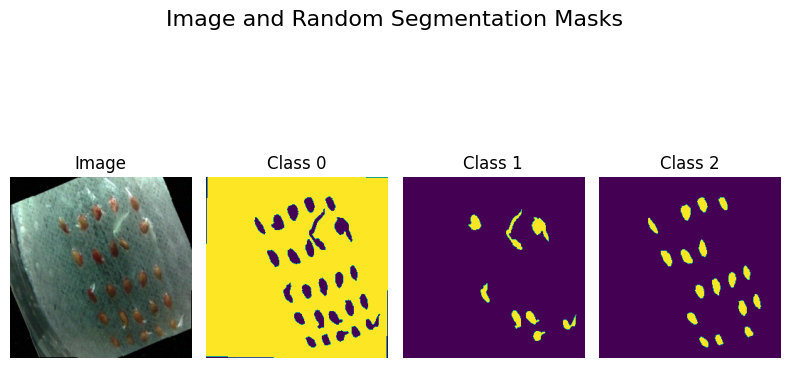

In [10]:
random_sample_visualization(dataset=train_dataset, num_classes=config["Number of classes"],
                            single_class=config['Single class train'],type='baseline')

### Cross-Entropy Loss

In [ ]:
wandb.login(key="YOUR_WANDB_API_KEY")
run = wandb.init()
artifact = run.use_artifact('gcpds/MasterTests/best_model:v157', type='model')
artifact_dir = artifact.download()

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: liturriago (gcpds) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb:   1 of 1 files downloaded.  


In [12]:
model = UNet(in_channels=config["Input size"][0],out_channels=config["Number of classes"],
             final_activation=config["Activation function"],backbone=config["Backbone"])
state_dict = torch.load('./artifacts/best_model:v157/best_model.pt', weights_only=True,map_location=torch.device('cpu'))
model.load_state_dict(state_dict)
model.eval()
model_nhwc = ai_edge_torch.to_channel_last_io(model, args=[0])

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 107MB/s] 


In [14]:
tfl_converter_flags = {'optimizations': [tf.lite.Optimize.DEFAULT]}

In [23]:
interpreter = Interpreter(model_path="./mobilenetv3_unet_dynamic.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("=== INPUTS ===")
for i, d in enumerate(input_details):
    print(f"Input {i}: name={d['name']} shape={d['shape']} dtype={d['dtype']}")

print("\n=== OUTPUTS ===")
for i, d in enumerate(output_details):
    print(f"Output {i}: name={d['name']} shape={d['shape']} dtype={d['dtype']}")

=== INPUTS ===
Input 0: name=serving_default_args_0:0 shape=[  1 256 256   3] dtype=<class 'numpy.float32'>

=== OUTPUTS ===
Output 0: name=StatefulPartitionedCall:0 shape=[  1   3 256 256] dtype=<class 'numpy.float32'>


In [22]:
C = config["Input size"][0]
sample_input = (torch.rand(1, 256, 256, C),)
edge_model = ai_edge_torch.convert(
    model_nhwc,
    sample_input,
    _ai_edge_converter_flags=tfl_converter_flags)
edge_model.export("mobilenetv3_unet_dynamic.tflite")

W0000 00:00:1764045325.374470      38 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1764045325.374527      38 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


In [24]:
sample = 72 

In [25]:
for indx, (image, mask) in enumerate(valid_dataset):
    image, mask
    if indx == sample:
        break

/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [26]:
with torch.no_grad():
    original_output = model(image)
    original_pred = torch.where(original_output > 0.5, 1, 0).cpu().numpy()

In [27]:
image_float32 = image.numpy().transpose(0, 2, 3, 1)  # [B, H, W, C]
print(f"Input shape: {image_float32.shape}, dtype: {image_float32.dtype}")

Input shape: (1, 256, 256, 3), dtype: float32


In [28]:
interpreter.set_tensor(input_details[0]['index'], image_float32.astype(np.float32))
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

In [29]:
# Output shape: [1, 3, H, W]
output_float = output_data[0]  # [3, H, W]
# Threshold
output_pred = np.where(output_float > 0.5, 1, 0)  # [3, H, W]

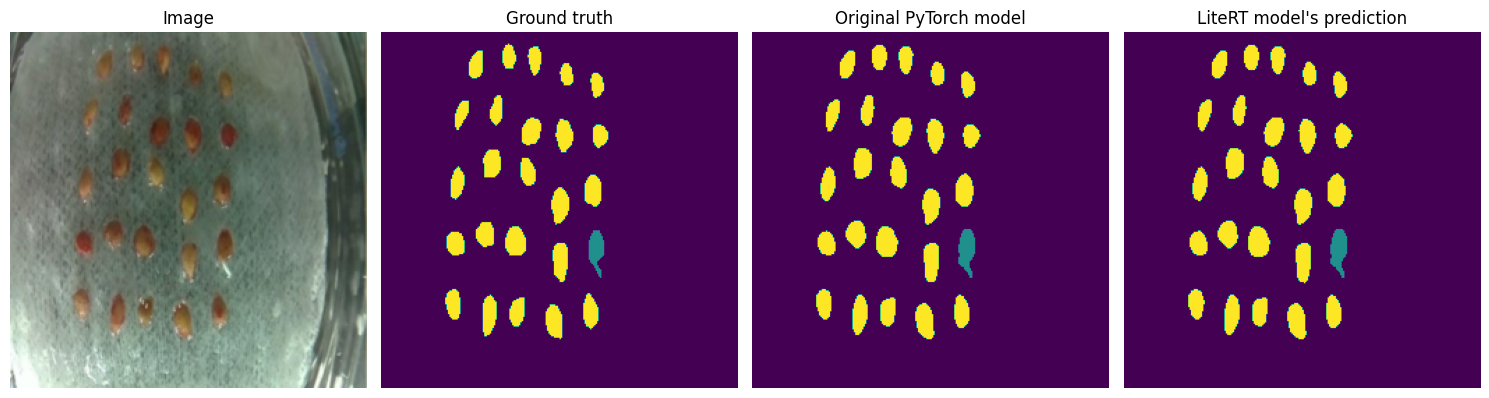

In [35]:
fig, axs = plt.subplots(1, 4, figsize=(15, 5))

# Imagen original
axs[0].imshow(image_float32[0])
axs[0].set_title("Image")
axs[0].axis('off')

# Ground truth
axs[1].imshow(np.argmax(mask[0, :, :, :], axis=0), vmin=0, vmax=2)
axs[1].set_title("Ground truth")
axs[1].axis('off')

# PyTorch prediction
axs[2].imshow(np.argmax(original_pred[0, :, :, :], axis=0), vmin=0, vmax=2)
axs[2].set_title("Original PyTorch model")
axs[2].axis('off')

# LiteRT prediction
axs[3].imshow(np.argmax(output_pred[:, :, :], axis=0), vmin=0, vmax=2)
axs[3].set_title("LiteRT model's prediction")
axs[3].axis('off')

plt.tight_layout()
fig.savefig('Example_inference_comparison_dynamic.pdf',
            dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [42]:
class ComparePerformanceModels:
    """
    A class for comparing the performance of PyTorch and LiteRT segmentation models.
    
    This class evaluates both models on the same test dataset and calculates
    metrics such as DICE, Jaccard, sensitivity, specificity, and inference time.
    """
    
    def __init__(self, pytorch_model, litert_model_path, test_dataset, config):
        """
        Initialize with dynamic quantization verification.
        
        Args:
            pytorch_model: PyTorch model instance
            litert_model_path: Path to LiteRT model file
            test_dataset: Test dataset loader
            config: Configuration dictionary
        """
        self.pytorch_model = pytorch_model
        self.litert_model_path = litert_model_path
        self.test_dataset = test_dataset
        self.config = config
        
        self.device = torch.device(self.config.get('Device', 'cpu'))
        
        # Setup PyTorch model
        self.pytorch_model.to(self.device)
        self.pytorch_model.eval()
        
        # Setup LiteRT model
        self.interpreter = Interpreter(model_path=self.litert_model_path)
        self.interpreter.allocate_tensors()
        
        self.input_details = self.interpreter.get_input_details()
        self.output_details = self.interpreter.get_output_details()
        
        # Verify dynamic quantization
        input_dtype = self.input_details[0]['dtype']
        output_dtype = self.output_details[0]['dtype']
        
        if input_dtype != np.float32 or output_dtype != np.float32:
            print(f"   WARNING: This model does NOT appear to use dynamic quantization")
            print(f"   Input type: {input_dtype} (expected: float32)")
            print(f"   Output type: {output_dtype} (expected: float32)")
            print(f"   Using standard inference with dequantization...")
            
            # Fallback to standard quantization
            self.scale_in, self.zero_point_in = self.input_details[0]['quantization']
            self.scale_out, self.zero_point_out = self.output_details[0]['quantization']
            
            # Use parent method
            super().__init__(pytorch_model, litert_model_path, test_dataset, config)
            return
        
        print(f"   Dynamic quantization model detected")
        print(f"   Input: {input_dtype}")
        print(f"   Output: {output_dtype}")
        
        # No quantization parameters needed for I/O
        self.scale_in = None
        self.zero_point_in = None
        self.scale_out = None
        self.zero_point_out = None
        
        # Run comparison
        self.compare()
    
    def compare(self) -> None:
        """
        Compare both models on the test dataset and calculate performance metrics.
        """
        self.smooth = self.config.get('Smooth', 1.0)
        
        # Initialize metric storage for both models
        pytorch_metrics = self._initialize_metrics()
        litert_metrics = self._initialize_metrics()
        
        # Inference time tracking
        pytorch_times = []
        litert_times = []
        
        num_classes = self.config.get('Number of classes', 1)
        is_single_class = isinstance(self.config.get("Single class test"), int)
        if is_single_class:
            num_classes = 1
        
        for data_batch in tqdm(self.test_dataset, desc="Comparing models"):
            images, gt_masks = data_batch
            
            # PyTorch inference
            pytorch_pred, pytorch_time = self._pytorch_inference(images)
            pytorch_times.append(pytorch_time)
            
            # LiteRT inference
            litert_pred, litert_time = self._litert_inference(images)
            litert_times.append(litert_time)
            
            # Prepare ground truth
            gt_masks = gt_masks.to(self.device)
            y_true = gt_masks.float()
            
            # Class selection
            if is_single_class:
                class_idx = self.config["Single class test"]
                pytorch_pred = pytorch_pred[:, class_idx:class_idx+1]
                litert_pred = litert_pred[:, class_idx:class_idx+1]
            
            # Create mask for valid pixels
            ignore_value = torch.tensor(self.config.get('Ignored value', 0.6), device=self.device)
            mask = (y_true != ignore_value).float()
            
            # Calculate metrics for both models
            self._update_metrics(pytorch_metrics, y_true, pytorch_pred, mask, num_classes)
            self._update_metrics(litert_metrics, y_true, litert_pred, mask, num_classes)
        
        # Convert metrics to numpy arrays
        pytorch_results = self._finalize_metrics(pytorch_metrics)
        litert_results = self._finalize_metrics(litert_metrics)
        
        # Print comparison results
        self._print_comparison(pytorch_results, litert_results, pytorch_times, litert_times, num_classes)
        
        # Clean up memory
        self._cleanup_memory()
    
    def _initialize_metrics(self) -> Dict[str, List]:
        """
        Initialize empty metric storage.
        
        Returns:
            Dictionary with empty lists for each metric
        """
        num_classes = self.config.get('Number of classes', 1)
        is_single_class = isinstance(self.config.get("Single class test"), int)
        if is_single_class:
            num_classes = 1
            
        return {
            'dice_global': [],
            'jaccard_global': [],
            'sensitivity_global': [],
            'specificity_global': [],
            'dice_per_class': [[] for _ in range(num_classes)],
            'jaccard_per_class': [[] for _ in range(num_classes)],
            'sensitivity_per_class': [[] for _ in range(num_classes)],
            'specificity_per_class': [[] for _ in range(num_classes)]
        }
    
    def _pytorch_inference(self, images: torch.Tensor) -> Tuple[torch.Tensor, float]:
        """
        Run inference with PyTorch model.
        
        Args:
            images: Input images tensor
            
        Returns:
            Tuple of (predictions, inference_time)
        """
        images = images.to(self.device)
        
        start_time = time.time()
        with torch.no_grad():
            y_pred = self.pytorch_model(images)
            y_pred = torch.where(y_pred > 0.5, torch.ones_like(y_pred), torch.zeros_like(y_pred))
        inference_time = time.time() - start_time
        
        return y_pred.float(), inference_time
    
    def _litert_inference(self, images: torch.Tensor) -> Tuple[torch.Tensor, float]:
        """
        LiteRT inference with FP32 input/output (dynamic quantization).
        
        Args:
            images: Input images tensor [B, C, H, W]
            
        Returns:
            Tuple of (predictions, inference_time)
        """
        batch_size = images.shape[0]
        target_shape = images.shape  # [B, C, H, W]
        
        # Convert to numpy and transpose to [B, H, W, C]
        image_float32 = images.numpy().transpose(0, 2, 3, 1)
        
        # KEY DIFFERENCE: DO NOT quantize input (already FP32)
        # For dynamic quantization, input is FP32 directly
        
        # Process batch
        all_predictions = []
        
        start_time = time.time()
        for i in range(batch_size):
            single_image = image_float32[i:i+1].astype(np.float32)
            
            # Run inference
            self.interpreter.set_tensor(self.input_details[0]['index'], single_image)
            self.interpreter.invoke()
            output_data = self.interpreter.get_tensor(self.output_details[0]['index'])
            
            all_predictions.append(output_data)
        
        inference_time = time.time() - start_time
        
        # Stack predictions
        output_data = np.concatenate(all_predictions, axis=0)
        
        # KEY DIFFERENCE: Output is already FP32, no dequantization needed
        output_float = output_data.astype(np.float32)
        
        # Reshape to [B, C, H, W]
        if len(output_float.shape) == 4:
            if output_float.shape[1] == target_shape[2] and output_float.shape[2] == target_shape[3]:
                output_float = output_float.transpose(0, 3, 1, 2)
        
        # Threshold predictions
        output_pred = np.where(output_float > 0.5, 1, 0)
        
        # Convert to torch tensor
        output_pred = torch.from_numpy(output_pred).float().to(self.device)
        
        return output_pred, inference_time
    
    def _calculate_batch_metrics(
        self, 
        y_true: torch.Tensor, 
        y_pred: torch.Tensor, 
        mask: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Calculate metrics for a single batch.
        
        Args:
            y_true: Ground truth segmentation masks [B, C, H, W]
            y_pred: Predicted segmentation masks [B, C, H, W]
            mask: Mask of valid pixels [B, C, H, W]
            
        Returns:
            Tuple containing dice, jaccard, sensitivity, and specificity tensors [B, C]
        """
        # Apply mask
        y_true_masked = y_true * mask
        y_pred_masked = y_pred * mask
        
        # Calculate confusion matrix components
        tp = torch.sum(y_true_masked * y_pred_masked, dim=(2, 3))
        fp = torch.sum((1 - y_true_masked) * y_pred_masked, dim=(2, 3))
        fn = torch.sum(y_true_masked * (1 - y_pred_masked), dim=(2, 3))
        tn = torch.sum((1 - y_true_masked) * (1 - y_pred_masked), dim=(2, 3))
        
        # Calculate metrics
        dice_batch = (2 * tp + self.smooth) / (2 * tp + fp + fn + self.smooth)
        jaccard_batch = (tp + self.smooth) / (tp + fp + fn + self.smooth)
        sensitivity_batch = (tp + self.smooth) / (tp + fn + self.smooth)
        specificity_batch = (tn + self.smooth) / (tn + fp + self.smooth)
        
        return dice_batch, jaccard_batch, sensitivity_batch, specificity_batch
    
    def _update_metrics(
        self, 
        metrics: Dict[str, List], 
        y_true: torch.Tensor, 
        y_pred: torch.Tensor, 
        mask: torch.Tensor,
        num_classes: int
    ) -> None:
        """
        Calculate and update metrics for a batch.
        
        Args:
            metrics: Dictionary to store metrics
            y_true: Ground truth masks
            y_pred: Predicted masks
            mask: Valid pixel mask
            num_classes: Number of classes
        """
        # Calculate batch metrics
        dice_batch, jaccard_batch, sensitivity_batch, specificity_batch = \
            self._calculate_batch_metrics(y_true, y_pred, mask)
        
        # Aggregate global metrics
        dice = torch.mean(dice_batch, dim=1)
        jaccard = torch.mean(jaccard_batch, dim=1)
        sensitivity = torch.mean(sensitivity_batch, dim=1)
        specificity = torch.mean(specificity_batch, dim=1)
        
        # Handle NaN values
        dice = torch.where(torch.isnan(dice), torch.tensor(0.0, device=self.device), dice)
        jaccard = torch.where(torch.isnan(jaccard), torch.tensor(0.0, device=self.device), jaccard)
        sensitivity = torch.where(torch.isnan(sensitivity), torch.tensor(0.0, device=self.device), sensitivity)
        specificity = torch.where(torch.isnan(specificity), torch.tensor(0.0, device=self.device), specificity)
        
        # Store global metrics
        metrics['dice_global'].extend(dice.tolist())
        metrics['jaccard_global'].extend(jaccard.tolist())
        metrics['sensitivity_global'].extend(sensitivity.tolist())
        metrics['specificity_global'].extend(specificity.tolist())
        
        # Store per-class metrics
        for c in range(num_classes):
            metrics['dice_per_class'][c].extend(dice_batch[:, c].tolist())
            metrics['jaccard_per_class'][c].extend(jaccard_batch[:, c].tolist())
            metrics['sensitivity_per_class'][c].extend(sensitivity_batch[:, c].tolist())
            metrics['specificity_per_class'][c].extend(specificity_batch[:, c].tolist())
    
    def _finalize_metrics(self, metrics: Dict[str, List]) -> Dict[str, np.ndarray]:
        """
        Convert metric lists to numpy arrays.
        
        Args:
            metrics: Dictionary with metric lists
            
        Returns:
            Dictionary with metric numpy arrays
        """
        return {
            'dice_global': np.array(metrics['dice_global']),
            'jaccard_global': np.array(metrics['jaccard_global']),
            'sensitivity_global': np.array(metrics['sensitivity_global']),
            'specificity_global': np.array(metrics['specificity_global']),
            'dice_per_class': [np.array(class_results) for class_results in metrics['dice_per_class']],
            'jaccard_per_class': [np.array(class_results) for class_results in metrics['jaccard_per_class']],
            'sensitivity_per_class': [np.array(class_results) for class_results in metrics['sensitivity_per_class']],
            'specificity_per_class': [np.array(class_results) for class_results in metrics['specificity_per_class']]
        }
    
    def _print_comparison(
        self, 
        pytorch_results: Dict[str, np.ndarray],
        litert_results: Dict[str, np.ndarray],
        pytorch_times: List[float],
        litert_times: List[float],
        num_classes: int
    ) -> None:
        """
        Print comparison results between PyTorch and LiteRT models.
        
        Args:
            pytorch_results: PyTorch model metrics
            litert_results: LiteRT model metrics
            pytorch_times: PyTorch inference times
            litert_times: LiteRT inference times
            num_classes: Number of classes
        """
        print("\n" + "="*80)
        print("MODEL COMPARISON: PyTorch vs LiteRT")
        print("="*80)
        
        # Inference time comparison
        print("\n--- INFERENCE TIME ---")
        pytorch_time_mean = np.mean(pytorch_times)
        litert_time_mean = np.mean(litert_times)
        speedup = pytorch_time_mean / litert_time_mean
        
        print(f"PyTorch: {pytorch_time_mean*1000:.2f} ms/batch (std: {np.std(pytorch_times)*1000:.2f} ms)")
        print(f"LiteRT:  {litert_time_mean*1000:.2f} ms/batch (std: {np.std(litert_times)*1000:.2f} ms)")
        print(f"Speedup: {speedup:.2f}x {'(LiteRT faster)' if speedup > 1 else '(PyTorch faster)'}")
        
        # Global metrics comparison
        print("\n--- GLOBAL METRICS ---")
        metrics_names = ['dice_global', 'jaccard_global', 'sensitivity_global', 'specificity_global']
        display_names = ['Dice Coefficient', 'Jaccard Index', 'Sensitivity', 'Specificity']
        
        for metric_name, display_name in zip(metrics_names, display_names):
            pytorch_mean = np.mean(pytorch_results[metric_name])
            pytorch_std = np.std(pytorch_results[metric_name])
            litert_mean = np.mean(litert_results[metric_name])
            litert_std = np.std(litert_results[metric_name])
            diff = pytorch_mean - litert_mean
            diff_percent = (diff / pytorch_mean) * 100 if pytorch_mean != 0 else 0
            
            print(f"\n{display_name}:")
            print(f"  PyTorch: {pytorch_mean:.5f} ± {pytorch_std:.5f}")
            print(f"  LiteRT:  {litert_mean:.5f} ± {litert_std:.5f}")
            print(f"  Difference: {diff:.5f} ({diff_percent:+.2f}%)")
        
        # Per-class metrics comparison
        print("\n--- PER-CLASS METRICS ---")
        for c in range(num_classes):
            print(f"\nClass {c}:")
            
            for metric_name, display_name in [('dice_per_class', 'Dice'), 
                                              ('jaccard_per_class', 'Jaccard'),
                                              ('sensitivity_per_class', 'Sensitivity'),
                                              ('specificity_per_class', 'Specificity')]:
                pytorch_mean = np.mean(pytorch_results[metric_name][c])
                pytorch_std = np.std(pytorch_results[metric_name][c])
                litert_mean = np.mean(litert_results[metric_name][c])
                litert_std = np.std(litert_results[metric_name][c])
                diff = pytorch_mean - litert_mean
                diff_percent = (diff / pytorch_mean) * 100 if pytorch_mean != 0 else 0
                
                print(f"  {display_name}:")
                print(f"    PyTorch: {pytorch_mean:.5f} ± {pytorch_std:.5f}")
                print(f"    LiteRT:  {litert_mean:.5f} ± {litert_std:.5f}")
                print(f"    Difference: {diff:.5f} ({diff_percent:+.2f}%)")
        
        print("\n" + "="*80)
    
    def _cleanup_memory(self) -> None:
        """
        Clean up memory by releasing tensors and running garbage collection.
        """
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

In [43]:
comparator = ComparePerformanceModels(
    pytorch_model=model,
    litert_model_path="./mobilenetv3_unet_dynamic.tflite",
    test_dataset=test_dataset,
    config=config
)

   Dynamic quantization model detected
   Input: <class 'numpy.float32'>
   Output: <class 'numpy.float32'>


Comparing models: 100%|██████████| 118/118 [00:31<00:00,  3.76it/s]



MODEL COMPARISON: PyTorch vs LiteRT

--- INFERENCE TIME ---
PyTorch: 111.22 ms/batch (std: 8.79 ms)
LiteRT:  144.45 ms/batch (std: 3.18 ms)
Speedup: 0.77x (PyTorch faster)

--- GLOBAL METRICS ---

Dice Coefficient:
  PyTorch: 0.87772 ± 0.10643
  LiteRT:  0.87900 ± 0.10361
  Difference: -0.00128 (-0.15%)

Jaccard Index:
  PyTorch: 0.82171 ± 0.12257
  LiteRT:  0.82203 ± 0.12068
  Difference: -0.00032 (-0.04%)

Sensitivity:
  PyTorch: 0.89149 ± 0.09921
  LiteRT:  0.89236 ± 0.09710
  Difference: -0.00087 (-0.10%)

Specificity:
  PyTorch: 0.96635 ± 0.02221
  LiteRT:  0.96678 ± 0.02163
  Difference: -0.00043 (-0.04%)

--- PER-CLASS METRICS ---

Class 0:
  Dice:
    PyTorch: 0.99596 ± 0.00233
    LiteRT:  0.99593 ± 0.00235
    Difference: 0.00003 (+0.00%)
  Jaccard:
    PyTorch: 0.99196 ± 0.00460
    LiteRT:  0.99191 ± 0.00463
    Difference: 0.00005 (+0.01%)
  Sensitivity:
    PyTorch: 0.99514 ± 0.00360
    LiteRT:  0.99507 ± 0.00361
    Difference: 0.00007 (+0.01%)
  Specificity:
    PyTor